In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [62]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Check that gradients can flow across channel:

In [3]:
channel = CommChannel(size=10, temperature=1, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

tf.Tensor([[0.14892802 0.1040659  0.7442691  0.00273695]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.4901161e-08, 1.4901161e-08, 5.9604645e-08, 2.3283064e-10]],
      dtype=float32)>

In [4]:
channel(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Load Data:

In [5]:
NUM_CLASSES = 3
BATCH_SIZE = 32
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [6]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

In [7]:
inputs, targets = generate_train_batch()

In [8]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

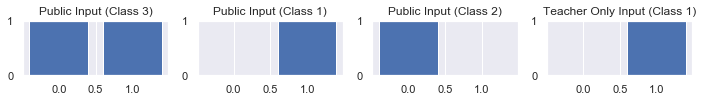

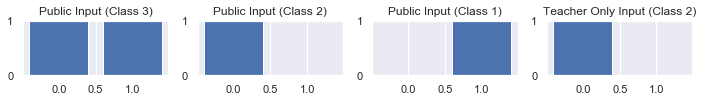

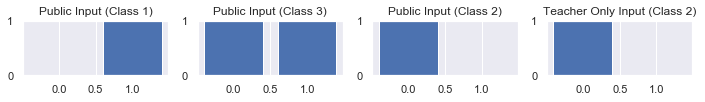

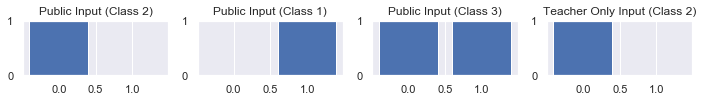

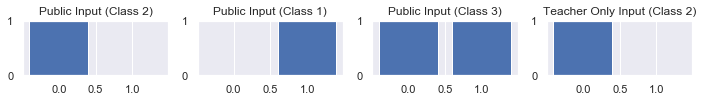

In [9]:
class_labels = list(TRAIN_DATA.keys())

if USE_MNIST:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for i, (ax, inp, tar) in enumerate(zip(axs, inputs, targets)):
        l = tar[row].numpy().argmax() + 1
        if i < NUM_CLASSES:
            ax.set_title(f'Public Input (Class {l})')
        else:
            ax.set_title(f'Teacher Only Input (Class {l})')
        if USE_MNIST:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [10]:
history = []
comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
tf.transpose([
    tf.argmax(item['message_from_teacher'], axis=-1) 
    for item in history
])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[2, 4, 0, 3],
       [4, 0, 1, 2],
       [3, 1, 2, 4],
       [4, 2, 1, 3],
       [4, 2, 0, 3]], dtype=int64)>

## Create Data-Specific Input Encoder

In [11]:
if USE_MNIST:
    encoder_latent_dim = 64
    _, *img_shape = x_train.shape
    AGENT_INPUT_ENCODER = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=img_shape),
            tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(encoder_latent_dim),
        ]
    )

else: 
    AGENT_INPUT_ENCODER = None

CHANNEL_SIZE = 5

### Checking Gradients of Agent Parameters with Respect to Loss Function:

In [12]:
teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

inputs, targets = generate_train_batch()

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student, 
                        training=True, 
                        p_mutate=0.5)

    loss = combined_loss_fn(outputs, targets)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)
student_grads = tape.gradient(loss, student.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

print()

for v, g in zip(student.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 0.04728681594133377
agent/dense/bias:0 teacher grad norm: 0.04016035795211792
agent/lstm/kernel:0 teacher grad norm: 0.08190501481294632
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.01801007241010666
agent/lstm/bias:0 teacher grad norm: 0.03294916823506355
agent/dense_1/kernel:0 teacher grad norm: 0.03272642940282822
agent/dense_1/bias:0 teacher grad norm: 0.023172274231910706

agent/dense_2/kernel:0 student grad norm: 0.008620542474091053
agent/dense_2/bias:0 student grad norm: 0.016221046447753906
agent/lstm_1/kernel:0 student grad norm: 0.01359584927558899
agent/lstm_1/recurrent_kernel:0 student grad norm: 0.008353834971785545
agent/lstm_1/bias:0 student grad norm: 0.016282252967357635
agent/dense_3/kernel:0 student grad norm: 1.6081945896148682
agent/dense_3/bias:0 student grad norm: 2.3911542892456055


In [13]:
teacher.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1664      
_________________________________________________________________
lstm (LSTM)                  multiple                  49408     
_________________________________________________________________
dense_1 (Dense)              multiple                  520       
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0     

In [14]:
inputs, targets = generate_train_batch()
outputs = play_game(inputs, teacher, student,
                    p_mutate=0.5, 
                    training=False)

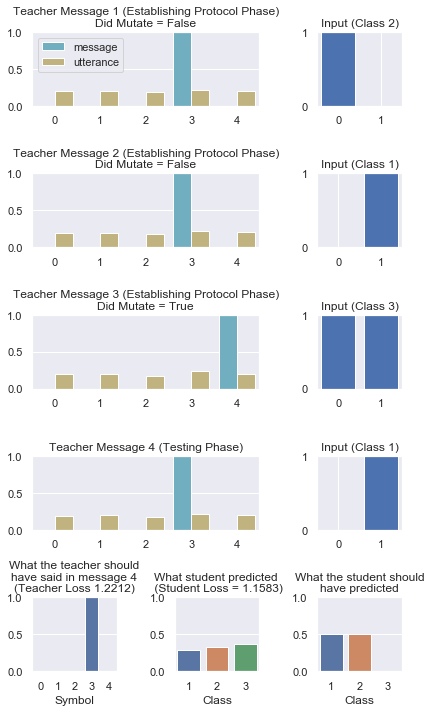

In [15]:
plot_game(inputs, outputs, targets, select_batch=1)

In [16]:
inputs, targets = generate_train_batch()

import unittest.mock as mock
synth_student = mock.MagicMock(return_value=(None, None, None))


with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, synth_student, 
                        training=True, 
                        stop_gradients_on_all_comm=False,
                        p_mutate=0)

    loss = protocol_diversity_loss(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 2.02083420753479
agent/dense/bias:0 teacher grad norm: 1.7504734992980957
agent/lstm/kernel:0 teacher grad norm: 3.7582128047943115
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.46843966841697693
agent/lstm/bias:0 teacher grad norm: 1.927030086517334
agent/dense_1/kernel:0 teacher grad norm: 1.9535622596740723
agent/dense_1/bias:0 teacher grad norm: 4.073312282562256


# Run Experiments

In [17]:
def create_only_student_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': 1, 'stop_gradients_on_all_comm': True}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=teacher_test_message_is_correct
    )


def create_only_teacher_test_msg_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': 1, 'stop_gradients_on_all_comm': True}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        loss_fn=student_pred_matches_implied_class
    )


def create_only_teacher_create_protocol_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': 0}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=lambda o, t: protocol_diversity_loss(o)
    )

def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class
    )

def create_self_play_experiment(p_mutate=0.3):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn
    )

In [18]:
experiment = create_self_play_experiment()
print(experiment.get_config())

{'max_epochs': 40, 'steps_per_epoch': 50, 'epochs_optimised': 0, 'loss_fn': 'complete_loss_fn', 'play_params': {'p_mutate': 0.3}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.01, 'decay': 0.0, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}}


In [19]:
experiment.train()

Epoch 0, Time Taken (mm:ss): 0:41, Mean Loss: 3.866
Test Loss: 4.264, Ground Truth F1-Score: 0.341, Student Error: 1.099, Teacher Error: 0.784, Protocol Diversity: 0.466,
Epoch 1, Time Taken (mm:ss): 0:39, Mean Loss: 3.842
Epoch 2, Time Taken (mm:ss): 0:32, Mean Loss: 3.821
Epoch 3, Time Taken (mm:ss): 0:36, Mean Loss: 3.797
Epoch 4, Time Taken (mm:ss): 0:38, Mean Loss: 3.718
Epoch 5, Time Taken (mm:ss): 0:31, Mean Loss: 3.77
Test Loss: 3.826, Ground Truth F1-Score: 0.417, Student Error: 1.109, Teacher Error: 0.737, Protocol Diversity: 0.569,
Epoch 6, Time Taken (mm:ss): 0:33, Mean Loss: 3.426
Epoch 7, Time Taken (mm:ss): 0:41, Mean Loss: 2.931
Epoch 8, Time Taken (mm:ss): 0:29, Mean Loss: 2.497
Epoch 9, Time Taken (mm:ss): 0:30, Mean Loss: 1.827
Epoch 10, Time Taken (mm:ss): 0:35, Mean Loss: 1.731
Test Loss: 1.471, Ground Truth F1-Score: 0.875, Student Error: 0.261, Teacher Error: 0.089, Protocol Diversity: 0.94,
Epoch 11, Time Taken (mm:ss): 0:30, Mean Loss: 1.732
Epoch 12, Time Take

In [20]:
experiment2 = create_self_play_experiment()

In [21]:
experiment2.train()

Epoch 0, Time Taken (mm:ss): 0:33, Mean Loss: 3.866
Test Loss: 4.437, Ground Truth F1-Score: 0.321, Student Error: 1.108, Teacher Error: 0.898, Protocol Diversity: 0.456,
Epoch 1, Time Taken (mm:ss): 0:30, Mean Loss: 3.811
Training stopped.


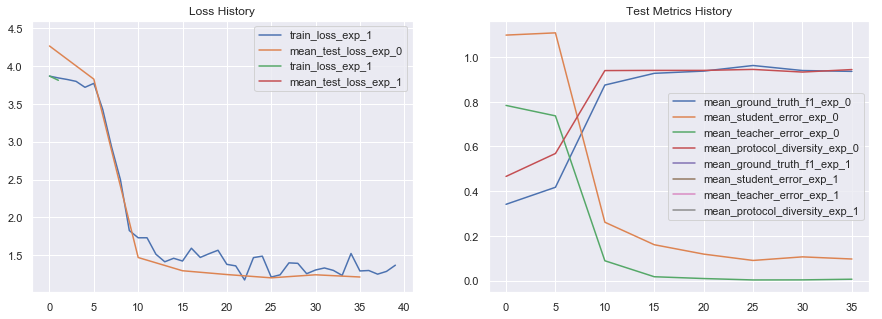

In [61]:
axs = experiment.plot_training_history()
experiment2.plot_training_history(axs=axs)

## Render Model Graph in Tensorboard

In [23]:
# # Set up logging.
# from datetime import datetime
# import tensorboard
# %load_ext tensorboard

# stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = f'logs\\{stamp}'
# writer = tf.summary.create_file_writer(logdir)

# # Bracket the function call with
# # tf.summary.trace_on() and tf.summary.trace_export().
# tf.summary.trace_off()
# tf.summary.trace_on(graph=True, profiler=True)
# # Call only one tf.function when tracing.

# @tf.function
# def graph_training_step():
#     return only_teacher_training_step(agent_1)

# graph_training_step()

# with writer.as_default():
#     tf.summary.trace_export(
#         name="teacher_only_training_step",
#         step=0,
#         profiler_outdir=logdir)
    
# tf.summary.trace_off()

In [24]:
# %tensorboard --logdir logs

## Analyse Trained Models

In [25]:
games_played, test_metrics = experiment.run_tests()
test_metrics

{'mean_test_loss': 1.258171796798706,
 'mean_ground_truth_f1': 0.9325,
 'mean_student_error': 0.11903975158929825,
 'mean_teacher_error': 0.005381997209042311,
 'mean_protocol_diversity': 0.9331250190734863}

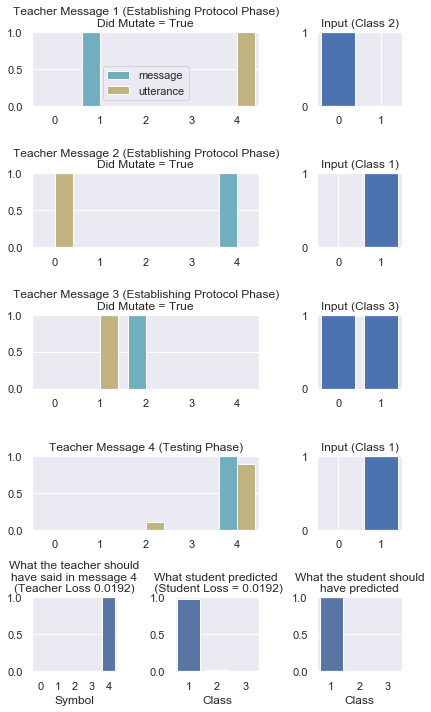

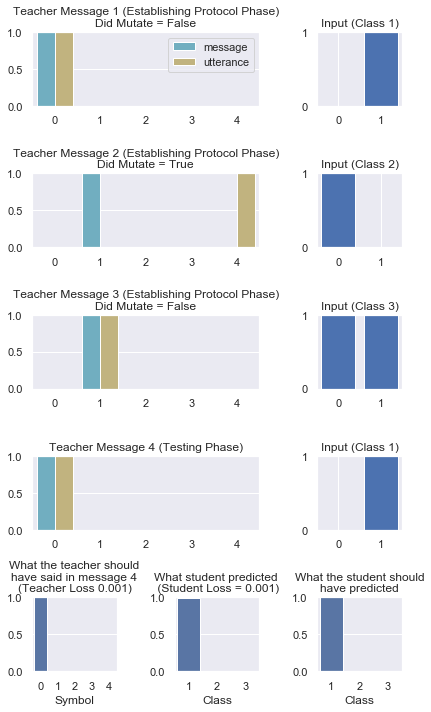

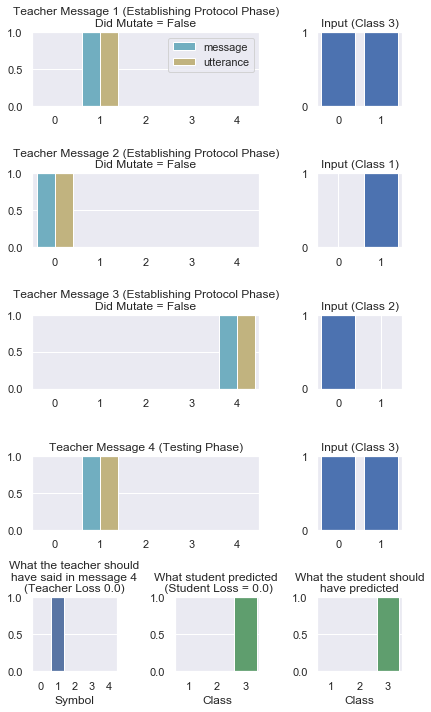

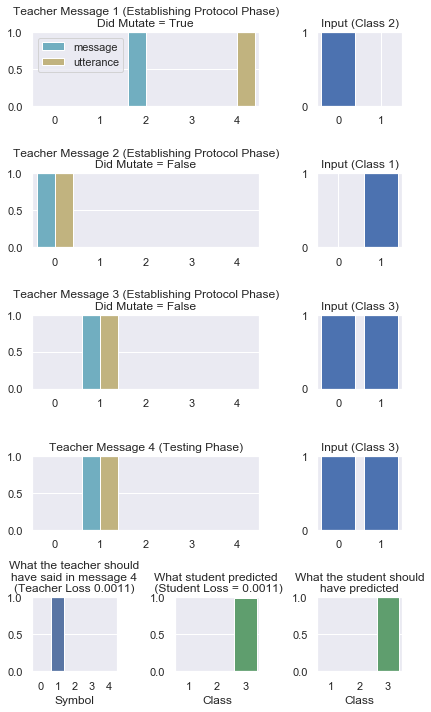

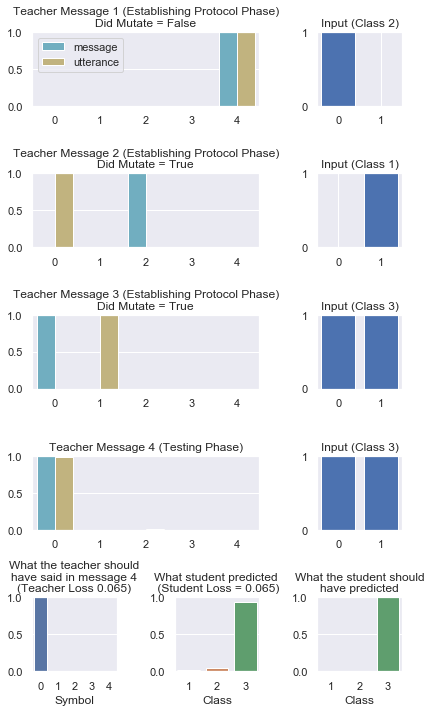

In [26]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

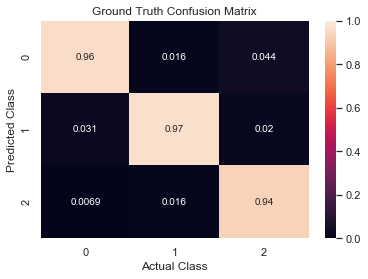

In [28]:
games_played, _ = experiment.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

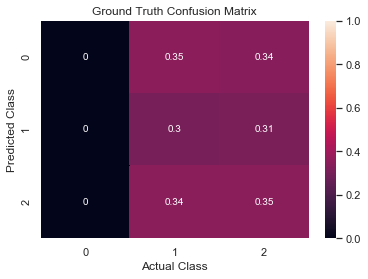

In [29]:
games_played, _ = experiment2.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

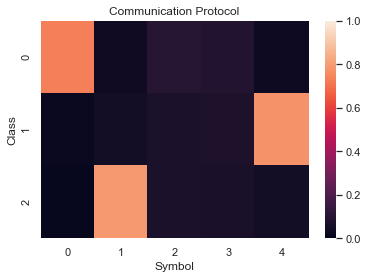

In [32]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

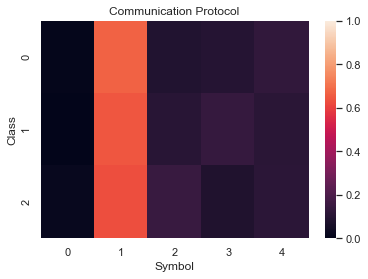

In [31]:
games_played, _ = experiment2.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

## Zero-shot Coordination

In [37]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment.teacher, 
    experiment2.student, 
    training=False, 
    p_mutate=0,
)

teacher_error, protocol_diversity = experiment.get_teacher_test_metrics([(inputs, targets, outputs)])
f1, student_error = experiment.get_student_test_metrics([(inputs, targets, outputs)])
loss = experiment.get_test_loss([(inputs, targets, outputs)])
print(f'Teacher Error: {teacher_error}, Protocol Diversity {protocol_diversity}, Student Error: {student_error}, F1 Score {f1}, Loss: {loss}')

Teacher Error: 8.847588333082967e-07, Protocol Diversity 1.0, Student Error: 1.1678869724273682, F1 Score 0.0, Loss: 2.1678876876831055


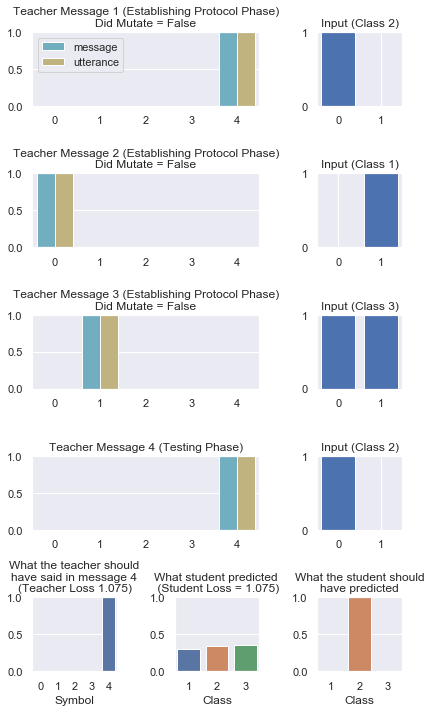

In [34]:
plot_game(inputs, outputs, targets, select_batch=1)

In [38]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment2.teacher, 
    experiment.student, 
    training=False, 
    p_mutate=0,
)

teacher_error, protocol_diversity = experiment.get_teacher_test_metrics([(inputs, targets, outputs)])
f1, student_error = experiment.get_student_test_metrics([(inputs, targets, outputs)])
loss = experiment.get_test_loss([(inputs, targets, outputs)])
print(f'Teacher Error: {teacher_error}, Protocol Diversity {protocol_diversity}, Student Error: {student_error}, F1 Score {f1}, Loss: {loss}')

Teacher Error: 0.3556617200374603, Protocol Diversity 0.3333333134651184, Student Error: 1.1909059286117554, F1 Score 0.1875, Loss: 4.546567916870117


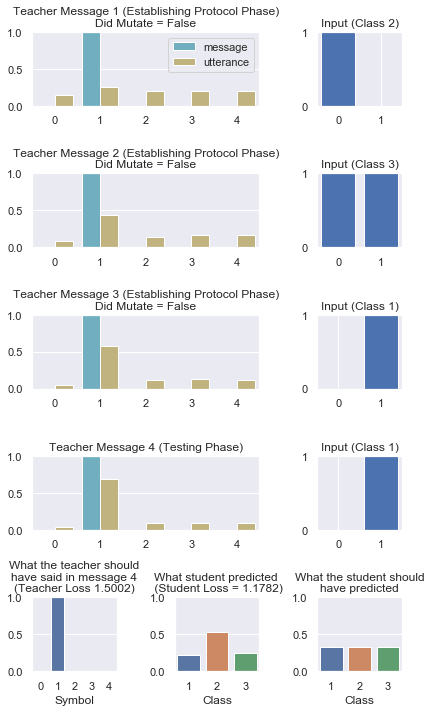

In [36]:
plot_game(inputs, outputs, targets)